In [5]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image
import os
from torchvision import transforms

class CustomImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file)  
        self.root_dir = root_dir  
        self.transform = transform
        self.label_map = {"building": 0, "leaves": 1}  # Mapping texte → nombre


    def __len__(self):
        return len(self.data_frame)  

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.data_frame.iloc[idx, 0]) 
        image = Image.open(img_path).convert("RGB")  
        label = self.label_map[self.data_frame.iloc[idx, 1]]

        if self.transform:
            image = self.transform(image)  

        return image, label  


In [7]:
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

def get_train_valid_loader(csv_file, root_dir, batch_size, augment, random_seed, valid_size=0.1, shuffle=True):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    # Définir les transformations pour validation et test
    valid_transform = transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.ToTensor(),
        normalize,
    ])

    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(227, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((227, 227)),
            transforms.ToTensor(),
            normalize,
        ])

    # Charger les datasets
    full_dataset = CustomImageDataset(csv_file=csv_file, root_dir=root_dir, transform=train_transform)
    valid_dataset = CustomImageDataset(csv_file=csv_file, root_dir=root_dir, transform=valid_transform)

    num_train = len(full_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = DataLoader(full_dataset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler)

    return train_loader, valid_loader

def get_test_loader(csv_file, root_dir, batch_size, shuffle=True):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    transform = transforms.Compose([
        transforms.Resize((227, 227)),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = CustomImageDataset(csv_file=csv_file, root_dir=root_dir, transform=transform)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    return data_loader

train_loader, valid_loader = get_train_valid_loader(
    csv_file="./data.csv", 
    root_dir=".",
    batch_size=64, 
    augment=False, 
    random_seed=1
)

test_loader = get_test_loader(
    csv_file="./data.csv",
    root_dir=".",
    batch_size=64
)



In [8]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [9]:
num_classes = 2
num_epochs = 10
batch_size = 90
learning_rate = 0.005
model = AlexNet(num_classes).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  

# Train the model
total_step = len(train_loader)

In [10]:
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images
        labels = labels
        # Forward pass
        outputs = model(images)
        output = outputs[0]
        label = labels[0]
        print(label)
        loss = criterion(output , label)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))

tensor(1)
Epoch [1/10], Step [1/1], Loss: 0.5314
Accuracy of the network on the 5000 validation images: 40.0 %
tensor(0)
Epoch [2/10], Step [1/1], Loss: 1.9992
Accuracy of the network on the 5000 validation images: 60.0 %
tensor(0)
Epoch [3/10], Step [1/1], Loss: 0.2488
Accuracy of the network on the 5000 validation images: 60.0 %
tensor(0)
Epoch [4/10], Step [1/1], Loss: 0.0313
Accuracy of the network on the 5000 validation images: 60.0 %
tensor(0)
Epoch [5/10], Step [1/1], Loss: 0.0005
Accuracy of the network on the 5000 validation images: 60.0 %
tensor(0)
Epoch [6/10], Step [1/1], Loss: 0.0000
Accuracy of the network on the 5000 validation images: 60.0 %
tensor(0)
Epoch [7/10], Step [1/1], Loss: 0.0000
Accuracy of the network on the 5000 validation images: 60.0 %
tensor(0)
Epoch [8/10], Step [1/1], Loss: 0.0000
Accuracy of the network on the 5000 validation images: 60.0 %
tensor(0)
Epoch [9/10], Step [1/1], Loss: 0.0000
Accuracy of the network on the 5000 validation images: 60.0 %
t

In [11]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs
    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

Accuracy of the network on the 10000 test images: 59.64912280701754 %


In [12]:
import numpy as np
import matplotlib.pyplot as plt
labels = [[] for _ in range(len(os.listdir("../data")))]
total = 0
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transform = transforms.Compose([
    transforms.Resize((227, 227)),  # Resize 
    transforms.RandomCrop(227, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize,
])

with torch.no_grad():
    data_folder = "../data"
    
    for i, folders in enumerate(os.listdir(data_folder)):
        data_folder_data = os.path.join(data_folder, folders)
        for j, filename in enumerate(os.listdir(data_folder_data)):
            data_file = os.path.join(data_folder_data, filename)
            if(plt.imread(data_file).shape[0] < 64):
                continue   
            if(plt.imread(data_file).shape[1] < 64):
                continue
            image = Image.open(data_file).convert("RGB")
            
            image = transform(image).unsqueeze(0)
      
            output = model(image)
            _, predicted = torch.max(output, 1)
            label_map = {0: "building", 1: "leaves"}
            predicted_label = label_map[predicted.item()]
            labels[i].append(predicted_label)
            total +=1
            
            
            
            
            
            
            


[['building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building'], ['building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building', 'building'], ['building', 'building', 'building'

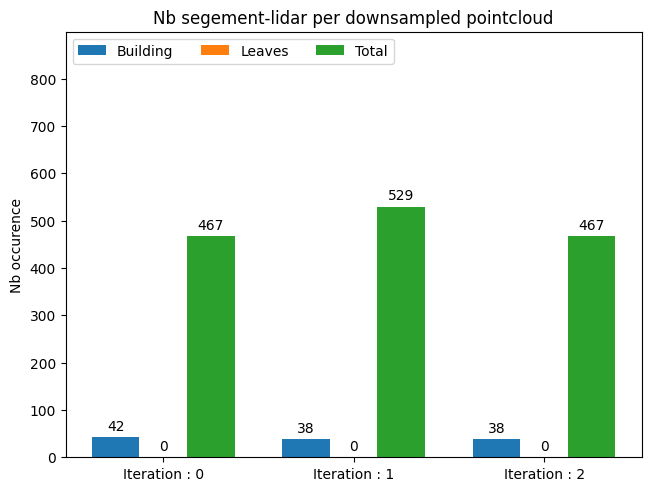

In [13]:
import matplotlib.pyplot as plt
import numpy as np

contours = labels
len_contours = len(contours)
print(contours)
species = list()
for i in range(len_contours):
    species.append("Iteration : "+str(i))
informations = {
    'Building': [0] * len_contours,
    'Leaves': [0] * len_contours,
    'Total': [0] * len_contours,
}

for i in range(len(contours)):
    for j in range(len(contours[i])):
        if(contours[i][j] == "building"):
            informations['Building'][i] = informations['Building'][i] + 1
        else:
            informations['Leaves'][i] = informations['Leaves'][i] +1
           
data_folder = "../data"
for i, folders in enumerate(sorted(os.listdir(data_folder))):
        for j, filename in enumerate(sorted(os.listdir(os.path.join(data_folder, folders)))): 
                informations['Total'][i] = informations['Total'][i] + 1

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in informations.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Nb occurence')
ax.set_title('Nb segement-lidar per downsampled pointcloud')
ax.set_xticks(x + width, species)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, max(informations['Total'])*1.7)

plt.show()